# Visual Recognition

**International Master in Computer Vision**

2021/2022

***openCV***

***scikit-image***

https://peerj.com/articles/453/#

https://scikit-image.org/


## Gabor Filters and GIST sample code ...

###### gabor_kernel(frequency, theta, bandwidth, sigma_x, sigma_y, n_stds,offset,...)

Parameters
-----------
* frequency: float. Spatial frequency of the harmonic function. Specified in pixels.
* theta: float, optional. Orientation in radians. If 0, the harmonic is in the x-direction.
* bandwidth: float, optional. The bandwidth captured by the filter. For fixed bandwidth, sigma_x and sigma_y will decrease with increasing frequency. This value is ignored if sigma_x and sigma_y are set by the user.
* sigma_x, sigma_y: float, optional. Standard deviation in x- and y-directions. These directions apply to the kernel *before* rotation. If theta = pi/2, then the kernel is rotated 90 degrees so that sigma_x controls the vertical direction.
* n_stds: scalar, optional. The linear size of the kernel standard deviations. 3 by default.
* offset: float, optional. Phase offset of harmonic function in radians.
  
Returns
-------
* real, imag: arrays. Filtered images using the real and imaginary parts of the Gabor filter kernel. Images are of the same dimensions as the input one.



### Gabor Features simple statistics for matching

Examples of Gabor filterings:


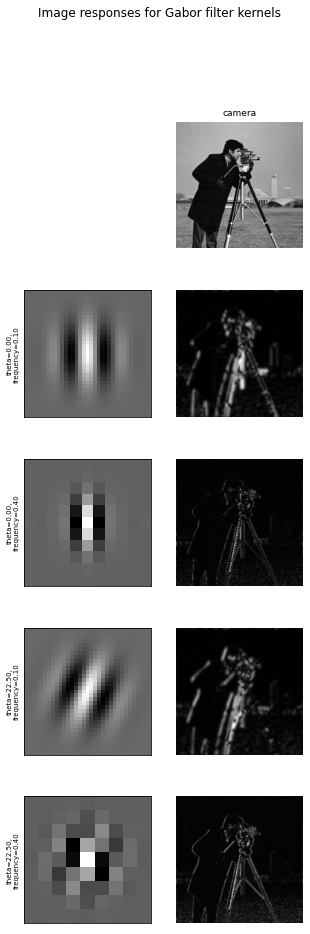

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats.append(filtered)
    return feats

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)


#downsampled images
image = img_as_float(data.camera())
image_name = 'camera'

 

print('Examples of Gabor filterings:')

# Plot a selection of the filter bank kernels and their responses.
N_orient=8

results = []
kernel_params = []
for theta_id in (0, 1):
    theta = theta_id / N_orient * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%.2f,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, power(image, kernel)) )


        
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(5, 15))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')


# Plot original images
#for label, img, ax in zip(image_names, images, axes[0][0]):


# Plot original images
label=image_name
ax=axes[0][1]
#for label, img, ax in zip(image_names, images, axes[0][1:]):
ax.imshow(image)
ax.set_title(label, fontsize=9)
ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel))
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    ax=ax_row[1]

    #for patch, ax in zip(powers, ax_row[1:]):
    ax.imshow(powers, vmin=vmin, vmax=vmax)
    ax.axis('off')
plt.show()

### GIST Descriptor

Test image: camera
Image size: (512, 512)


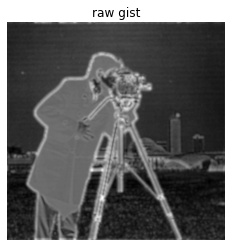

Gist descriptor size: 512


In [57]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel


def compute_gist_descriptor(img_loc):
    # build average feature map:
    
    def make_square(img):
        """turns an image into a square
        assumes the image is grayscale
        for sides divisible by 4
        """
        r, c = img.shape

        side4 = (int(min([r,c])/4)) * 4

        one_edge = side4//2
        img1 = img[((r//2)-one_edge):((r//2)+one_edge), ((c//2)-one_edge):((c//2)+one_edge)]

        r, c = img1.shape
        return img1[:min([r,c]), :min([r,c])]
    
    def compute_avg(img):
        img = make_square(img)
        r,c = img.shape

        chunks_row = np.split(np.array(range(r)), 4)
        chunks_col = np.split(np.array(range(c)), 4)

        grid_images = []

        for row in chunks_row:
            for col in chunks_col:
                grid_images.append(np.mean(img[np.min(row):np.max(row), np.min(col):np.max(col)]))
        return np.array(grid_images).reshape((4,4))

    def power(image, kernel):
        # Normalize images for better comparison.
        image = (image - image.mean()) / image.std()
        return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)
        
    def power_single(gs):
        (kernel, powers) = gs
        return powers*255

    images = img_loc #cv2.imread(img_loc, cv2.COLOR_GRAY2BGR) # shrink makes the image smaller...
    images = make_square(images)
    images = images/255.0
    
    # Plot a selection of the filter bank kernels and their responses.
    results = []
    kernel_params = []    
    N_orient=8
    sigma=3
    for theta in range(0, N_orient):
        theta = theta / N_orient * np.pi
        for frequency in (0.1, 0.2, 0.3, 0.4):
            kernel = gabor_kernel(frequency, theta=theta,sigma_x=sigma, sigma_y=sigma)
            params = 'theta=.2%f,\nfrequency=%.2f,\nsigma=%.2f' % (theta * 180 / np.pi, frequency, sigma)
            kernel_params.append(params)
            # Save kernel and the power image for each image
            results.append((kernel, power(images, kernel)))
    
    gist_global=np.zeros(power_single(results[0]).shape)

    for i in range(len(results)):
        gist_global=gist_global+power_single(results[i])
        
    smallest = np.amin(gist_global)
    biggest = np.amax(gist_global)
    gist_norm= (gist_global-smallest)/(biggest-smallest)*255
    gist_gray=np.uint8(gist_norm)
    smallest = np.amin(gist_gray)
    biggest = np.amax(gist_gray)
    
    imgplot = plt.imshow(gist_gray)
    plt.title("raw gist")
    plt.axis('off')
    plt.show()

    
    return np.array([compute_avg(power_single(img)) for img in results]).reshape(512)


#downsampled images
#shrink = (slice(0, None, 3), slice(0, None, 3))
camera = img_as_float(data.camera())#[shrink]
horse = img_as_float(data.horse())#[shrink]
clock = img_as_float(data.clock())#[shrink]
image_names = ('camera', 'horse', 'clock')
images = (camera, horse, clock)

test_im=images[0]
test_im_name=image_names[0]

print('Test image: {}'.format(test_im_name))
print('Image size: {}'.format(test_im.shape))
rotation=0
#test_im=ndi.rotate(grass, angle=rotation, reshape=False)


test_gist_descriptor = compute_gist_descriptor(test_im)

print('Gist descriptor size: {}'.format(test_gist_descriptor.size))
#print(test_gist_descriptor)

## SIFT

#### SIFT is a local descriptor to characterize local gradient information. SIFT descriptor was presented as a sparse feature representation that consists of both feature detection and description. 

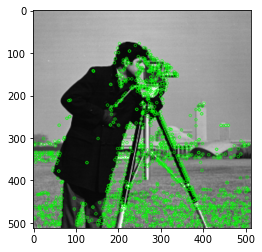

In [12]:
import cv2  
from skimage import data
import matplotlib.pyplot as plt
# Loading the image
img = data.camera()
  
# Converting image to grayscale
#img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  
# Applying SIFT detector
sift = cv2.SIFT_create()
kp = sift.detect(img,None)


img_sift_kp=cv2.drawKeypoints(img,kp,None,color=(0,255,0), flags=0)
  
# Marking the keypoint on the image using circles

  
plt.imshow(img_sift_kp)
plt.show()

## Dense SIFT Descriptor

#### For category recognition however, we usually only use the feature description component. For every grid point in an image, we divide its neighborhood (e.g. 16×16) into a 4×4 cell array, quantize the orientation into 8 bins in each cell, and obtain a 4×4×8=128-dimensional vector as the SIFT representation for a pixel. 

##### dsift.py: 
This function implements some basic functions that does dense sift feature extraction.
The descriptors are defined in a similar way to the one used in Svetlana Lazebnik's Matlab implementation, which could be found at: http://www.cs.unc.edu/~lazebnik/

Yangqing Jia, jiayq@eecs.berkeley.edu

Image: w 451, h 300, gs 8, ps 16, nFea 1980


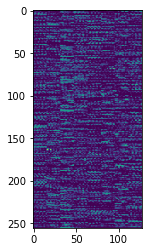

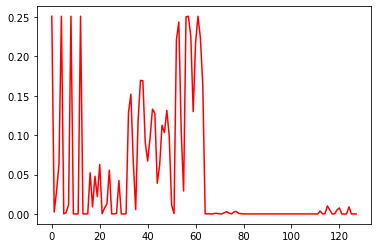

In [13]:
import numpy as np
from scipy import signal
from matplotlib import pyplot
from skimage import data

# sift features
Nangles = 8
Nbins = 4
Nsamples = Nbins**2
alpha = 9.0
angles = np.array(range(Nangles))*2.0*np.pi/Nangles

def gen_dgauss(sigma):
    '''
    generating a derivative of Gauss filter on both the X and Y direction.
    '''
    fwid = np.int(2*np.ceil(sigma))
    G = np.array(range(-fwid,fwid+1))**2
    G = G.reshape((G.size,1)) + G
    G = np.exp(- G / 2.0 / sigma / sigma)
    G /= np.sum(G)
    GH,GW = np.gradient(G)
    GH *= 2.0/np.sum(np.abs(GH))
    GW *= 2.0/np.sum(np.abs(GW))
    return GH,GW

class DsiftExtractor:
    '''
    The class that does dense sift feature extractor.
    Sample Usage:
        extractor = DsiftExtractor(gridSpacing,patchSize,[optional params])
        feaArr,positions = extractor.process_image(Image)
    '''
    def __init__(self, gridSpacing, patchSize,
                 nrml_thres = 1.0,\
                 sigma_edge = 0.8,\
                 sift_thres = 0.2):
        '''
        gridSpacing: the spacing for sampling dense descriptors
        patchSize: the size for each sift patch
        nrml_thres: low contrast normalization threshold
        sigma_edge: the standard deviation for the gaussian smoothing before computing the gradient
        sift_thres: sift thresholding (0.2 works well based on Lowe's SIFT paper)
        '''
        self.gS = gridSpacing
        self.pS = patchSize
        self.nrml_thres = nrml_thres
        self.sigma = sigma_edge
        self.sift_thres = sift_thres
        # compute the weight contribution map
        sample_res = self.pS / np.double(Nbins)
        sample_p = np.array(range(self.pS))
        sample_ph, sample_pw = np.meshgrid(sample_p,sample_p)
        sample_ph.resize(sample_ph.size)
        sample_pw.resize(sample_pw.size)
        bincenter = np.array(range(1,Nbins*2,2)) / 2.0 / Nbins * self.pS - 0.5 
        bincenter_h, bincenter_w = np.meshgrid(bincenter,bincenter)
        bincenter_h.resize((bincenter_h.size,1))
        bincenter_w.resize((bincenter_w.size,1))
        dist_ph = abs(sample_ph - bincenter_h)
        dist_pw = abs(sample_pw - bincenter_w)
        weights_h = dist_ph / sample_res
        weights_w = dist_pw / sample_res
        weights_h = (1-weights_h) * (weights_h <= 1)
        weights_w = (1-weights_w) * (weights_w <= 1)
        # weights is the contribution of each pixel to the corresponding bin center
        self.weights = weights_h * weights_w
        #pyplot.imshow(self.weights)
        #pyplot.show()
        
    def process_image(self, image, positionNormalize = True,verbose = True):
        '''
        processes a single image, return the locations and the values of detected SIFT features.
        image: a M*N image which is a numpy 2D array. Color images will automatically be converted to grayscale.
        positionNormalize: whether to normalize the positions to [0,1]. If False, the pixel-based positions of the
            top-right position of the patches is returned.
        
        Return values:
        feaArr: the feature array, each row is a feature positions: the positions of the features
        '''

        image = image.astype(np.double)
        if image.ndim == 3:
            # we do not deal with color images.
            image = np.mean(image,axis=2)
        # compute the grids
        H,W = image.shape
        gS = self.gS
        pS = self.pS
        remH = np.mod(H-pS, gS)
        remW = np.mod(W-pS, gS)
        offsetH = int(remH/2)
        offsetW = int(remW/2)
        gridH,gridW = np.meshgrid(range(offsetH,H-pS+1,gS), range(offsetW,W-pS+1,gS))
        gridH = gridH.flatten()
        gridW = gridW.flatten()
        if verbose:
            print('Image: w {}, h {}, gs {}, ps {}, nFea {}'.format(W,H,gS,pS,gridH.size))
        feaArr = self.calculate_sift_grid(image,gridH,gridW)
        feaArr = self.normalize_sift(feaArr)
        if positionNormalize:
            positions = np.vstack((gridH / np.double(H), gridW / np.double(W)))
        else:
            positions = np.vstack((gridH, gridW))
        return feaArr, positions

    def calculate_sift_grid(self,image,gridH,gridW):
        '''
        This function calculates the unnormalized sift features
        It is called by process_image().
        '''
        H,W = image.shape
        Npatches = gridH.size
        feaArr = np.zeros((Npatches,Nsamples*Nangles))

        # calculate gradient
        GH,GW = gen_dgauss(self.sigma)
        IH = signal.convolve2d(image,GH,mode='same')
        IW = signal.convolve2d(image,GW,mode='same')
        Imag = np.sqrt(IH**2+IW**2)
        Itheta = np.arctan2(IH,IW)
        Iorient = np.zeros((Nangles,H,W))
        for i in range(Nangles):
            Iorient[i] = Imag * np.maximum(np.cos(Itheta - angles[i])**alpha,0)
            #pyplot.imshow(Iorient[i])
            #pyplot.show()
        for i in range(Npatches):
            currFeature = np.zeros((Nangles,Nsamples))
            for j in range(Nangles):
                currFeature[j] = np.dot(self.weights,\
                        Iorient[j,gridH[i]:gridH[i]+self.pS, gridW[i]:gridW[i]+self.pS].flatten())
            feaArr[i] = currFeature.flatten()
        return feaArr

    def normalize_sift(self,feaArr):
        '''
        This function does sift feature normalization following David Lowe's definition 
         (normalize length -> thresholding at 0.2 -> renormalize length)
        '''
        siftlen = np.sqrt(np.sum(feaArr**2,axis=1))
        hcontrast = (siftlen >= self.nrml_thres)
        siftlen[siftlen < self.nrml_thres] = self.nrml_thres
        # normalize with contrast thresholding
        feaArr /= siftlen.reshape((siftlen.size,1))
        # suppress large gradients
        feaArr[feaArr>self.sift_thres] = self.sift_thres
        # renormalize high-contrast ones
        feaArr[hcontrast] /= np.sqrt(np.sum(feaArr[hcontrast]**2,axis=1)).\
                reshape((feaArr[hcontrast].shape[0],1))
        return feaArr

class SingleSiftExtractor(DsiftExtractor):
    '''
    The simple wrapper class that does feature extraction, treating
    the whole image as a local image patch.
    '''
    def __init__(self, patchSize,
                 nrml_thres = 1.0,\
                 sigma_edge = 0.8,\
                 sift_thres = 0.2):
        # simply call the super class __init__ with a large gridSpace
        DsiftExtractor.__init__(self, patchSize, patchSize, nrml_thres, sigma_edge, sift_thres)   
    
    def process_image(self, image):
        return DsiftExtractor.process_image(self, image, False, False)[0]
    
if __name__ == '__main__':
    # ignore this. I only use this for testing purpose...
    
    extractor = DsiftExtractor(8,16,1)
    image = data.chelsea()
    feaArr,positions = extractor.process_image(image)
    #pyplot.hist(feaArr.flatten(),bins=100)
    #pyplot.imshow(feaArr[:256])
    #pyplot.plot(np.sum(feaArr,axis=0))
    pyplot.imshow(feaArr[np.random.permutation(feaArr.shape[0])[:256]])
    
    # test single sift extractor
    extractor = SingleSiftExtractor(16)
    feaArrSingle = extractor.process_image(image[:16,:16])
    pyplot.figure()
    pyplot.plot(feaArr[0],'r')
    pyplot.plot(feaArrSingle,'b')
    pyplot.show()

## HOG descriptor: focuses on the structure or the shape of an object. It counts the occurrences of gradient orientation in localized portions of an image.
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html

Image size: (300, 451)
Number of cells 37 x56
Feature vector size 18648
Hog vector size: (18648,)


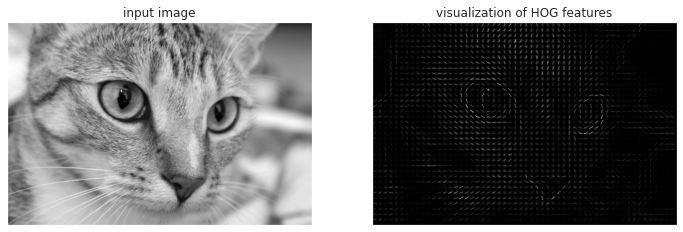

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
cell_size=(8,8)
orientations=9
hog_vec, hog_vis = feature.hog(image, orientations=orientations, pixels_per_cell=cell_size,
                    cells_per_block=(1, 1),visualize=True)

print('Image size: {}'.format(image.shape))
print('Number of cells {} x{}'.format(image.shape[0]//cell_size[0], image.shape[1]//cell_size[1]))
print('Feature vector size {}'.format((image.shape[0]//cell_size[0])*(image.shape[1]//cell_size[1])*orientations))
print('Hog vector size: {}'.format(hog_vec.shape))
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis,cmap='gray')
ax[1].set_title('visualization of HOG features');

## Sliding Window and Pyramids
Utilities to get image pyramids, sliding window locations, ...

(512, 512)
(256, 256)
(128, 128)
(64, 64)
(32, 32)


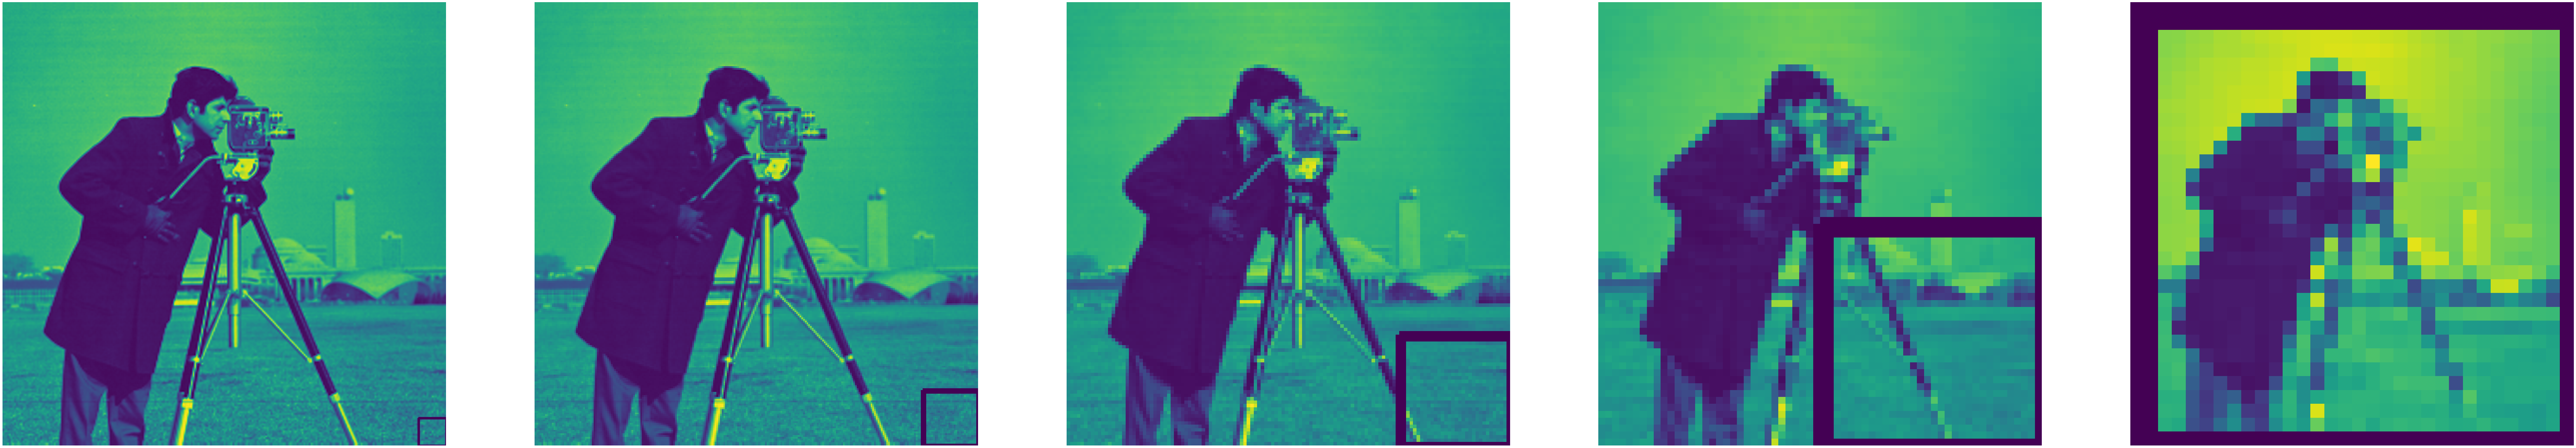

In [1]:
import imutils
import cv2
import matplotlib.pyplot as plt
import time
from skimage import data

def pyramid(image,scale=1.5,minSize=(32,32)):
	# yield the original image
	yield image
	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w=int(image.shape[1]/scale)
		image=imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0]<minSize[1] or image.shape[1]<minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

def sliding_window(image, stepSize, windowSize):
  #slide a window across the image
  for y in range(0,image.shape[0],stepSize):
    for x in range(0,image.shape[1],stepSize):
      #yield the current window
      yield (x,y,image[y:y+windowSize[1],x:x+windowSize[0]])

image= data.camera()
(winW,winH) = (32,32)

fig,ax=plt.subplots(1,5,figsize=(128,128))
#for i, axi in enumerate(ax.flat):

i=0
j=0

# loop over the image pyramid
for resized in pyramid(image, scale=2):
  # loop over the sliding window for each layer of the pyramid
  for (x,y,window) in sliding_window(resized,stepSize=32,windowSize=(winW, winH)):
    #if the window does not meet our desired window size, ignore it
    if window.shape[0]!=winH or window.shape[1]!=winW:
      continue
		#THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
		#MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
		#WINDOW
		#since we do not have a classifier, we'll just draw the window
    #i=(i+10)%256
    #clone=resized.copy()
    #cv2.rectangle(clone,(x, y),(x+winW,y+winH),(0,0,i),2)
    #ax[j].imshow(clone)
    #3time.sleep(0.25)
  print(resized.shape)
  i=(i+10)%256
  clone=resized.copy()
  cv2.rectangle(clone,(x, y),(x+winW,y+winH),(0,0,i),2)
  ax[j].imshow(clone)
  ax[j].axis('off')
  j=(j+1)